# rDNA location

In this notebook, we look at the properties of rDNA in the _A. castellanii_ genome.
5S rDNA are dispersed throughout the genome. Do they look randomly distributed or follow some kind of rules ?

In [154]:
import os
from typing import Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import pyfastx as px

In [151]:
os.chdir("/home/cmatthey/Repos/acastellanii_genome_analysis/")
rdna_c3 = pd.read_csv(
    'data/input/rnammer/C3.gff',
    comment='#',
    sep='\t',
    names=['chrom', 'start', 'end', 'score', 'rDNA'],
    usecols=[0, 3, 4, 5, 8]
)
rdna_neff = pd.read_csv(
    'data/input/rnammer/Neff.gff',
    comment='#',
    sep='\t',
    names=['chrom', 'start', 'end', 'score', 'rDNA'],
    usecols=[0, 3, 4, 5, 8]
)
chroms_neff = {x.name: len(x) for x in px.Fasta('data/input/genomes/Neff_assembly.fa')}
chroms_c3 = {x.name: len(x) for x in px.Fasta('data/input/genomes/C3_assembly.fa')}

In [96]:
def get_chrom_prop(chrom: str, pos: int, chroms: Dict[str, int]) -> float:
    """Given a chromosome name and position,
    return the relative distance from telomere (from 0 to 0.5)."""
    try:
        chromlen = chroms[chrom]
        return min(pos / chromlen, (chromlen - pos) / chromlen)
    except KeyError:
        return np.nan

rdna_c3['rel_pos'] = rdna_c3.loc[rdna_c3.rDNA == '8s_rRNA'].apply(
    lambda r: get_chrom_prop(r.chrom, r.start, chroms_c3), axis=1
)
rdna_neff['rel_pos'] = rdna_neff.loc[rdna_neff.rDNA == '8s_rRNA'].apply(
    lambda r: get_chrom_prop(r.chrom, r.start, chroms_neff), axis=1
)

In [97]:
rdna = pd.concat([rdna_c3, rdna_neff], axis=0)

<IPython.core.display.Javascript object>


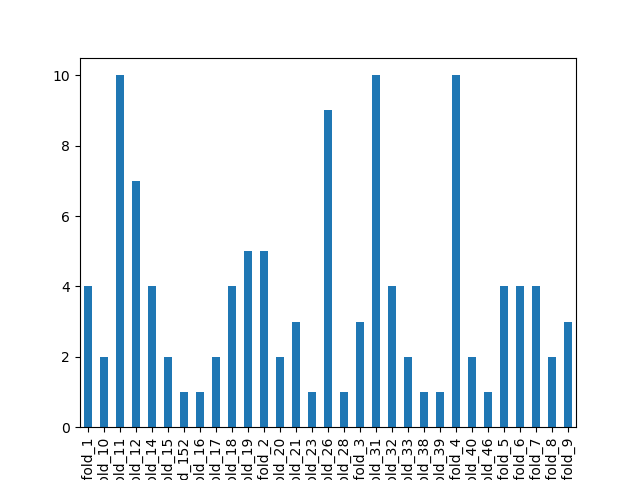

<AxesSubplot:xlabel='chrom'>

In [98]:
%matplotlib notebook
rdna_neff.groupby('chrom').count()['start'].plot(kind='bar')

<IPython.core.display.Javascript object>


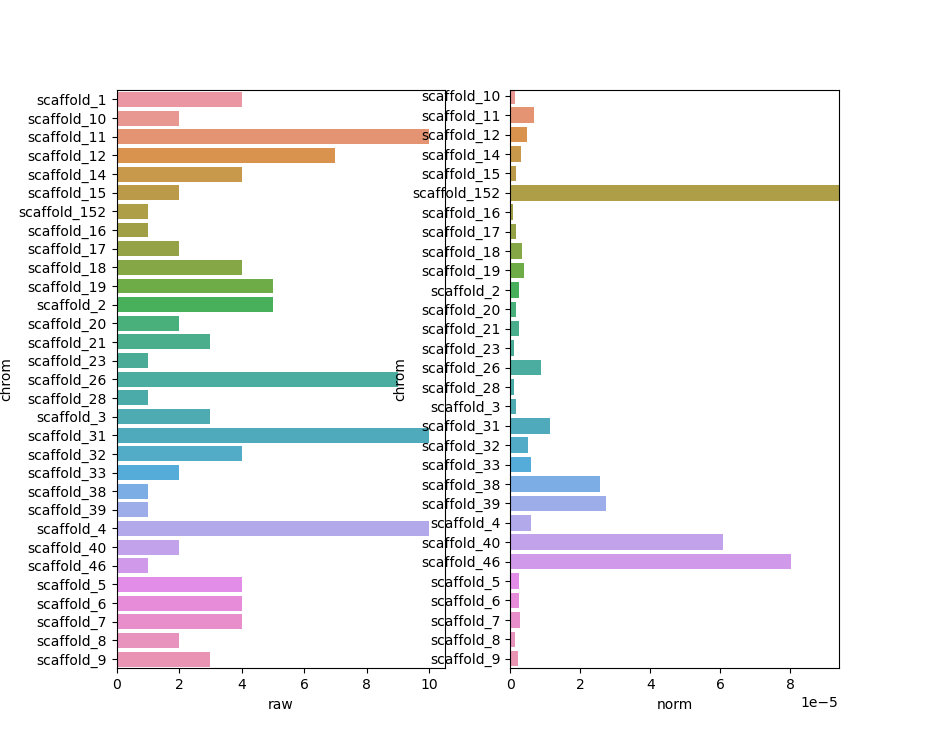

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='norm', ylabel='chrom'>

In [161]:
%matplotlib notebook
rdna_neff_dist = (
    rdna_neff
    .groupby('chrom')
    .count()['start']
    .reset_index()
    .rename(columns={'start': 'raw'})
)
rdna_neff_dist['norm'] = rdna_neff_dist.apply(lambda x: x.raw / chroms_neff[x.chrom], axis=1)
fig, ax = plt.subplots(1, 2)
sns.barplot(rdna_neff_dist.raw, rdna_neff_dist.chrom, ax=ax[0], orient='h')
sns.barplot(rdna_neff_dist.norm, rdna_neff_dist.chrom, ax=ax[1], orient='h')



<IPython.core.display.Javascript object>


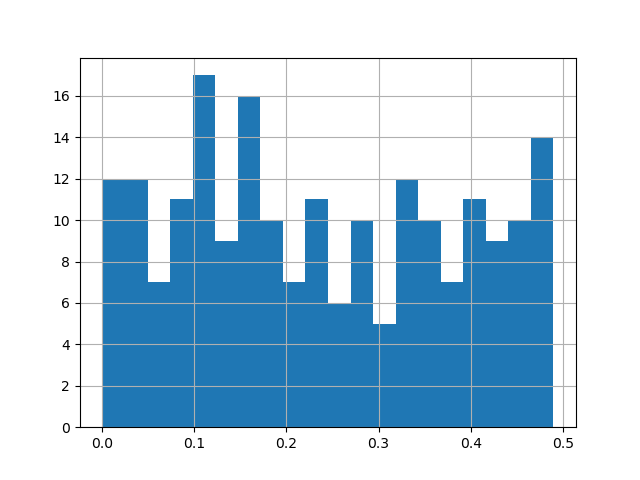

<AxesSubplot:>

In [162]:
%matplotlib notebook
rdna.rel_pos.hist(bins=20)

In [106]:
boots = []
for i in range(100):
    boots.append(
        rdna_neff.sample(rdna_neff.shape[0], replace=True).apply(
            lambda r: get_chrom_prop(r.chrom, r.start, chroms_neff), axis=1
        ).mean()
    )

In [110]:
np.mean(boots > rdna_neff.rel_pos.mean())

0.25

In [112]:
boots = []
for i in range(100):
    boots.append(
        rdna_c3.sample(rdna_c3.shape[0], replace=True).apply(
            lambda r: get_chrom_prop(r.chrom, r.start, chroms_c3), axis=1
        ).mean()
    )
np.mean(boots > rdna_c3.rel_pos.mean())

0.78

Overall, 5S rDNA is well distributed among chromosomes, and does not have a preference for telomeric or centromeric regions.